In [852]:
# Import required packages
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Allows plots to appear directly in the notebook.
%matplotlib inline

# Read csv file into a dataframe.
df = pd.read_csv('./stations/Princes Street O\'Connell Street.csv')

In [853]:
df = df.rename(columns={'round(avg(available_bikes))': 'avg_avail_bikes'})

In [854]:
df.avg_avail_bikes.mean()

18.452380952380953

In [855]:
df.dtypes

address            object
avg_avail_bikes     int64
HOUR                int64
DOW                object
last_update        object
rain_in_mm          int64
dtype: object

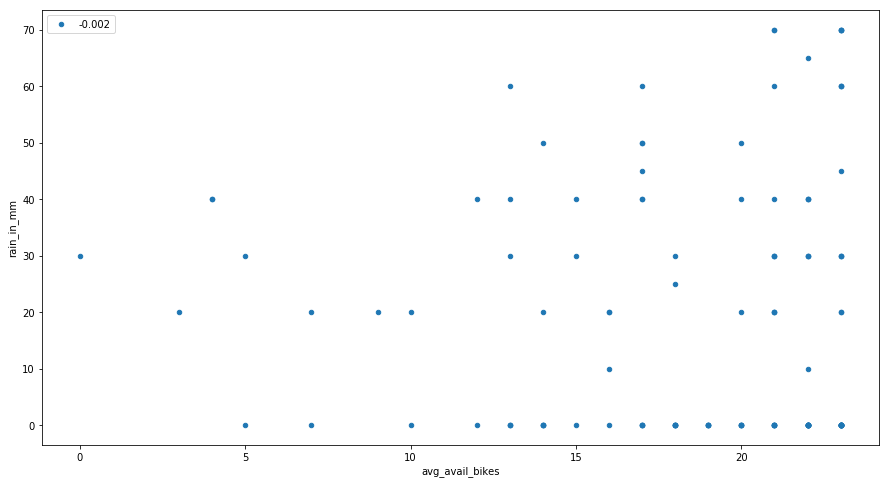

In [856]:
df.plot(kind='scatter', x='avg_avail_bikes', y='rain_in_mm', label="%.3f" % df[['rain_in_mm', 'avg_avail_bikes']].corr().as_matrix()[0,1], figsize=(15, 8))


In [857]:
df_dummies_DOW = pd.get_dummies(df[['DOW']])
df_dummies_DOW.head()

,DOW_Friday,DOW_Monday,DOW_Saturday,DOW_Sunday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [858]:
df_cont_feat = df[['HOUR','rain_in_mm']]

In [859]:
# Add dummies to the other continuous features
X = pd.concat([df_cont_feat, df_dummies_DOW[['DOW_Monday', 'DOW_Tuesday','DOW_Wednesday', 'DOW_Thursday','DOW_Friday', 'DOW_Saturday','DOW_Sunday']]], axis =1)
y = df.avg_avail_bikes
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

Descriptive features:
      HOUR  rain_in_mm  DOW_Monday  DOW_Tuesday  DOW_Wednesday  DOW_Thursday  \
0       6           0           0            0              0             1   
1       7           0           0            0              0             1   
2       8           0           0            0              0             1   
3       9           0           0            0              0             1   
4      10           0           0            0              0             1   
5      11          10           0            0              0             1   
6      12          30           0            0              0             1   
7      13          30           0            0              0             1   
8      14          45           0            0              0             1   
9      15          40           0            0              0             1   
10     16          30           0            0              0             1   
11     17          30        

In [860]:
# Train a classification tree with max_depth=3 on all data.
dtc = DecisionTreeClassifier(max_depth=3, random_state=1)
dtc.fit(X, y)
print(dtc)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


In [861]:
# Check the type of this object
type(dtc)

sklearn.tree.tree.DecisionTreeClassifier

In [862]:
# Compute the importance of each feature based on the trained decision tree classifier
pd.DataFrame({'feature': X.columns, 'importance': dtc.feature_importances_})

,feature,importance
0,HOUR,0.382428
1,rain_in_mm,0.133386
2,DOW_Monday,0.115297
3,DOW_Tuesday,0.149024
4,DOW_Wednesday,0.000000
5,DOW_Thursday,0.000000
6,DOW_Friday,0.000000
7,DOW_Saturday,0.000000
8,DOW_Sunday,0.219865


In [863]:
# Alternative to print a tree in text format
"""
treeviz.py

A simple tree visualizer for sklearn DecisionTreeClassifiers.

Written by Lutz Hamel, (c) 2017 - Univeristy of Rhode Island
"""
import operator

def tree_print(clf, X):
    """
    Print the tree of a sklearn DecisionTreeClassifier

    Parameters
    ----------
    clf : DecisionTreeClassifier - A tree that has already been fit.
    X : The original training set
    """
    tlevel = _tree_rprint('', clf, X.columns, clf.classes_)
    print('<',end='')
    for i in range(3*tlevel - 2):
        print('-',end='')
    print('>')
    print('Tree Depth: ',tlevel)

def _tree_rprint(kword, clf, features, labels, node_index=0, tlevel_index=0):
    # Note: The DecisionTreeClassifier uses the Tree structure defined in:
    # 		github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx
    #       it is an array based tree implementation:

    # indent the nodes according to their tree level
    for i in range(tlevel_index):
        print('  |',end='')

	#  TODO: the following should use the TREE_LEAF constant defined in _tree.pyx
	#        instead of -1, not quite sure how to get at it from the tree user level
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        print(kword, end=' ' if kword else '')
        # get the majority label
        count_list = clf.tree_.value[node_index, 0]
        max_index, max_value = max(enumerate(count_list), key=operator.itemgetter(1))
        max_label = labels[max_index]
        print(max_label)
        return tlevel_index
    
    else:
        # compute and print node label
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        print(kword, end=' ' if kword else '')
        print('if {} =< {}: '.format(feature, threshold))
        # recurse down the children
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        ltlevel_index = _tree_rprint('then', clf, features, labels, left_index, tlevel_index+1)
        rtlevel_index = _tree_rprint('else', clf, features, labels, right_index, tlevel_index+1)
        # return the maximum depth of either one of the children
        return max(ltlevel_index,rtlevel_index)

In [864]:
# Use the function tree_print defined above to plot a decision tree in text format
tree_print(dtc, X)

if HOUR =< 16.5: 
  |then if DOW_Tuesday =< 0.5: 
  |  |then if DOW_Sunday =< 0.5: 
  |  |  |then 23
  |  |  |else 23
  |  |else if HOUR =< 12.5: 
  |  |  |then 13
  |  |  |else 9
  |else if rain_in_mm =< 35.0: 
  |  |then if DOW_Monday =< 0.5: 
  |  |  |then 18
  |  |  |else 14
  |  |else if DOW_Sunday =< 0.5: 
  |  |  |then 13
  |  |  |else 17
<------->
Tree Depth:  3


In [865]:
predictions = dtc.predict(X)
df_true_vs_predicted = pd.DataFrame({'Actual_bike_numbers': df.avg_avail_bikes, 'Predicted_bike_numbers': predictions})
df_true_vs_predicted

,Actual_bike_numbers,Predicted_bike_numbers
0,23,23
1,22,23
2,20,23
3,21,23
4,22,23
5,22,23
6,21,23
7,22,23
8,23,23
9,22,23


In [866]:
#print("Accuracy: ", metrics.accuracy_score(y, predictions))
#print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
#print("Classification report:\n ", metrics.classification_report(y, predictions))
print(metrics.mean_absolute_error(y, predictions))

2.8333333333333335


In [867]:
scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=1), X, y, scoring='mean_absolute_error', cv=3)
print(scores)
print(scores.mean())

[-3.32653061 -3.53488372 -2.38235294]
-3.0812557581172


In [868]:
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [869]:
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [870]:
with open('./stations/Princes Street O\'Connell Street.pkl','wb') as output:
    pickle.dump(rfc, output, pickle.HIGHEST_PROTOCOL)

In [871]:
#with open('./stations/MountStrLower.pkl','rb') as input:
  #rfc = pickle.load(input)
    
  #rfc.predict(parameters)

In [872]:
rfc_predictions = rfc.predict(X)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y, 'PredictedClass': rfc_predictions})
df_true_vs_rfc_predicted

,ActualClass,PredictedClass
0,23,23
1,22,22
2,20,20
3,21,21
4,22,22
5,22,22
6,21,21
7,22,22
8,23,23
9,22,22


In [873]:
print(metrics.mean_absolute_error(y, rfc_predictions))

0.0


In [874]:
# This process is repeated 3 times. More details about cross-validation here: http://www-bcf.usc.edu/~gareth/ISL/
scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X, y, scoring='mean_absolute_error', cv=3)
print(scores)
print(scores.mean())

[-3.04081633 -3.         -6.41176471]
-4.150860344137655


In [875]:
rfc.oob_score_

0.29365079365079366

In [876]:
# X is hour and mm_rain and DOW
# rfc.predict(X) is the estimated number of bikes